In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from scroutines import basicu
from scroutines.config_plots import *
import importlib
importlib.reload(basicu)

<module 'scroutines.basicu' from '/scr/qlyu/projects/v1/scroutines/scroutines/basicu.py'>

In [2]:
sns.set_context('talk')

# get data

In [3]:
ddir = '../data/cheng21_cell_scrna/organized/'
files = [
    'P8NR.h5ad',
    'P14NR.h5ad',
    # 'P17NR.h5ad',
    # 'P21NR.h5ad',
    # 'P28NR.h5ad',
    # 'P38NR.h5ad',
    
#     'P28DR.h5ad',
#     'P38DR.h5ad',
    
#     'P28DL.h5ad',
] 

In [4]:
conds = np.array([f.replace('.h5ad', '') for f in files])
conds

array(['P8NR', 'P14NR'], dtype='<U5')

In [5]:
pbulks = []
xclsts = []
xcnsts = []

ncond, nrep, nclst, ngene = len(files), 2, 2,-1

for f in files:
    print(f)
    
    path = os.path.join(ddir, f)
    adata = anndata.read(path)
    genes = adata.var.index.values
    
    adata = adata[adata.obs['Subclass'] == 'L2/3']
    mat = adata.X
    types = adata.obs['Type'].astype(str).values 
    # 1 or 2
    sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1][:-1].replace('3', '2')).astype(str).values
    # sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1].replace('3', '2')).astype(str).values
    sample_and_type = sample_codes + "_" + types
    unqs, cnts = np.unique(sample_and_type, return_counts=True)
    _xclsts, Xk, Xk_n, Xk_ln = basicu.counts_to_bulk_profiles(mat, sample_and_type) 
    
    # check all types + reps are the same
    if len(xclsts) > 0:
        if not np.all(_xclsts == xclsts):
            raise ValueError(_xclsts.shape, xclsts.shape, _xclsts, xclsts,)
        if not np.all(_xclsts == unqs):
            raise ValueError(_xclsts.shape, unqs.shape, _xclsts, unqs,)
    else:
        xclsts = _xclsts
        print(xclsts)
        
    print(Xk_ln.shape)
    pbulks.append(Xk_ln)
    xcnsts.append(cnts)
    
pbulks = np.array(pbulks)
xcnsts = np.array(xcnsts)
print(pbulks.shape)
pbulks = pbulks.reshape(ncond,nrep,nclst,-1)
xcnsts = xcnsts.reshape(ncond,nrep,nclst)
xclsts = xclsts.reshape(      nrep,nclst)
print(pbulks.shape)

P8NR.h5ad
['1_L2/3_AB' '1_L2/3_BC' '2_L2/3_AB' '2_L2/3_BC']
(4, 53801)
P14NR.h5ad
(4, 53801)
(2, 4, 53801)
(2, 2, 2, 53801)


In [6]:
# check the pbulks are good -- log10(CPM+1) for each sample
checkpbulks = np.sum(np.power(10, pbulks)-1, axis=-1)
checkpbulks.shape, np.all(np.abs(checkpbulks-1e6) < 1e-6)

((2, 2, 2), True)

In [7]:
# xclsts_short = np.array([clst[len("1a_"):] for clst in xclsts[0]]) #, '_'
xclsts_short = np.array([clst[len("1_"):] for clst in xclsts[0]]) #, '_'
xclsts_short

array(['L2/3_AB', 'L2/3_BC'], dtype='<U7')

# filter out small bulk profiles

In [8]:
numcells = pd.DataFrame(xcnsts.T.reshape(-1,nrep*ncond), index=xclsts_short)
numcells

,0,1,2,3
L2/3_AB,676,2562,1670,1770
L2/3_BC,326,1125,711,790


In [9]:
numcells.min(axis=1).sort_values()

L2/3_BC    326
L2/3_AB    676
dtype: int64

In [10]:
xclsts_sel = xclsts_short[numcells.min(axis=1)>50]
unq_types = xclsts_sel
xclsts_selidx = basicu.get_index_from_array(xclsts_short, xclsts_sel)
pbulks = pbulks[:,:,xclsts_selidx,:]
xclsts_sel, xclsts_selidx

(array(['L2/3_AB', 'L2/3_BC'], dtype='<U7'), array([0, 1]))

# check the L23 type genes 

In [11]:
# f = "../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq.csv"
# df = pd.read_csv(f, header=None)
# genes_l23 = df[0].unique()
# genes_l23_grps = df[1] # .unique()
# df

In [12]:
# genes_l23_grps.unique()

In [13]:
f = "../results/MERFISH_gene_panel_current_Feb28.csv"
df = pd.read_csv(f)
# df['why included'].unique()
df = df[df['why included'].str.contains('L2/3/4 subtypes at P14')]

cnddts = df['gene_name_data'].values
unq, cnts = np.unique(cnddts, return_counts=True)
print(len(cnddts), unq.shape, unq[cnts>1], [g for g in cnddts if g not in genes])

df

23 (23,) [] []


,gene_name_vizgen,gene_name_data,why included,source,Annot1,Annot2,Annot3
407,Dner,Dner,L2/3/4 subtypes at P14,our analysis,P14 n=50,NaN,NaN
408,Lypd1,Lypd1,All cell types;L2/3/4 subtypes at P14,Chen22_biorxiv_Zador;our analysis,P14 n=50,NaN,NaN
409,Nckap5,Nckap5,L2/3/4 subtypes at P14;L2/3 dynamic,our analysis,P14 n=50,NaN,NaN
410,Cacnb2,Cacnb2,L2/3/4 subtypes at P14,our analysis,P14 n=50,NaN,NaN
411,Pde1a,Pde1a,L2/3/4 subtypes at P14,our analysis,P14 n=50,NaN,NaN
412,Plcb4,Plcb4,L2/3/4 subtypes at P14,our analysis,P14 n=50,NaN,NaN
413,Gm15155,Gm15155,L2/3/4 subtypes at P14,our analysis,P14 n=50,NaN,NaN
414,4921539H07Rik,4921539H07Rik,L2/3/4 subtypes at P14,our analysis,P14 n=50,NaN,NaN
415,Npnt,Npnt,L2/3/4 subtypes at P14,our analysis,P14 n=50,NaN,NaN
416,Gm20752,Gm20752,L2/3/4 subtypes at P14,our analysis,P14 n=50,NaN,NaN


In [14]:
genes_l23 = cnddts
# gidx_sub = basicu.get_index_from_array(genes_l23, cnddts)
ispicked = np.array([True]*len(cnddts)) #np.array([g in cnddts for g in genes_l23])
# gidx_sub, 
ispicked

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [15]:
gidx = basicu.get_index_from_array(genes, genes_l23)
assert np.all(gidx!=-1)
# xlbls = [''.join(i) for i in itertools.product(['A_', 'B_', 'C_'], ['P17', 'P21', 'P28', 'P38'], ['_1', '_2'])]
xlbls = [''.join(i) for i in itertools.product(['A_', 'B_', ], ['P8', 'P14',], ['_1', '_2'])]
pbulks.shape, xlbls

((2, 2, 2, 53801),
 ['A_P8_1',
  'A_P8_2',
  'A_P14_1',
  'A_P14_2',
  'B_P8_1',
  'B_P8_2',
  'B_P14_1',
  'B_P14_2'])

In [16]:
# xlbls_short = []
# for i, xlbl in enumerate(xlbls):
#     if i%(4*2) == 0:
#         short = "_".join(xlbl.split("_")[:2])
#     else:
#         short = xlbl.split("_")[1]
#     if i%2 == 1:
#         short = "" #xlbl.split("_")[-1]
#     xlbls_short.append(short)
    
# xlbls_short 
xlbls_short = xlbls

In [17]:
pbsub_a = basicu.merge_first_few_dims(pbulks[:,:,0,gidx]).T
pbsub_b = basicu.merge_first_few_dims(pbulks[:,:,1,gidx]).T
# pbsub_c = basicu.merge_first_few_dims(pbulks[:,:,2,gidx]).T
pbsub   = np.hstack([pbsub_a, pbsub_b,])# pbsub_c]) 

pbsub_logfc = pbsub-np.mean(pbsub, axis=1).reshape(-1,1)
pbsub_zscore = pbsub_logfc/np.std(pbsub_logfc, axis=1).reshape(-1,1) #-np.mean(pbsub, axis=1).reshape(-1,1)

In [18]:
maxexp = np.max([np.mean(pbsub_a, axis=1), 
                 np.mean(pbsub_b, axis=1), 
                 # np.mean(pbsub_c, axis=1),
                ], axis=0)

minexp = np.min([np.mean(pbsub_a, axis=1), 
                 np.mean(pbsub_b, axis=1), 
                 # np.mean(pbsub_c, axis=1),
                ], axis=0)
lfcexp = maxexp-minexp

lfcorder = np.argsort(lfcexp)
maxorder = np.argsort(maxexp)
minorder = np.argsort(minexp)

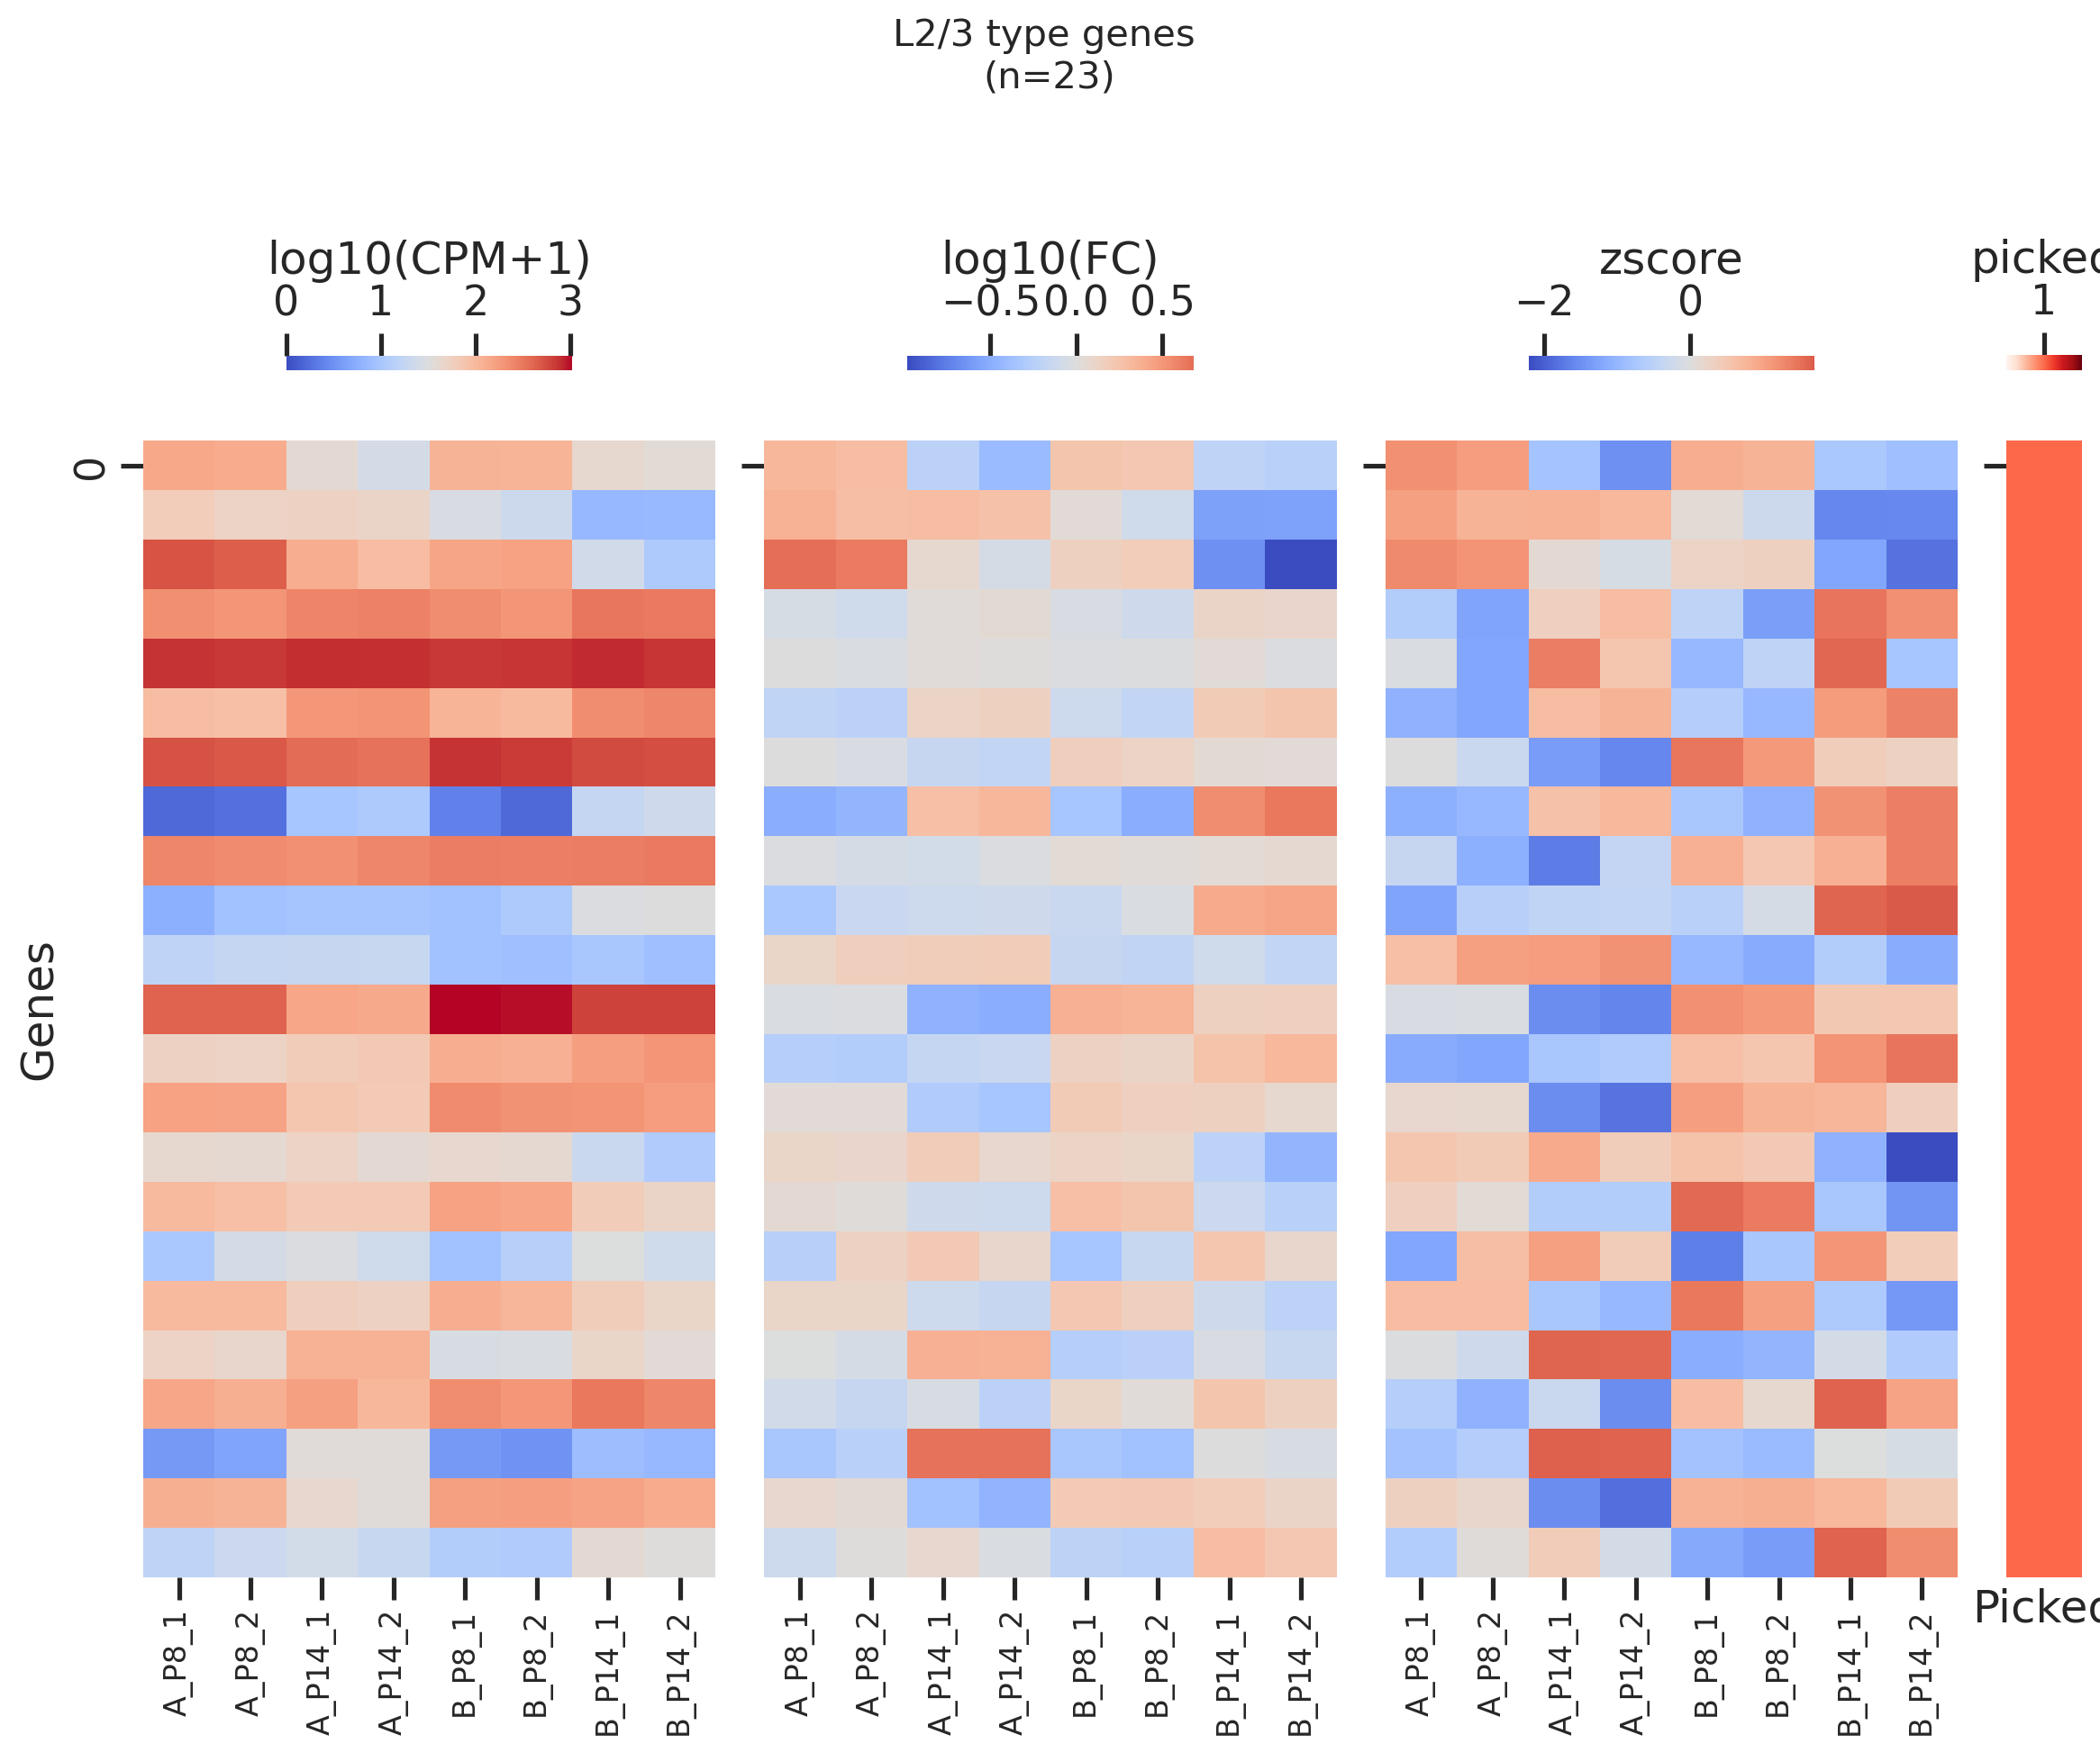

In [19]:

# fig, axs = plt.subplots(1, 3, figsize=(3*4,10), sharey=True)

fig, axs = plt.subplot_mosaic("A"*5+"B"*5+"C"*5+"D", figsize=(3*4,10), sharey=True)
fig.suptitle(f'L2/3 type genes \n(n={len(pbsub_a)})', fontsize=15)

ax = axs["A"]
sns.heatmap(pbsub, #[rowidx],
            yticklabels=50,
            xticklabels=xlbls_short, # tsdup,
            cmap='coolwarm', 
            cbar_kws=dict(location='top', shrink=0.5, label='log10(CPM+1)', ticks=[0,1,2,3]),
            vmin=0, 
            # vmax=3,
            ax=ax,
           )
# ax.set_xlabel('Samples')
ax.set_ylabel('Genes')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

ax = axs["B"]
sns.heatmap(pbsub_logfc, #[rowidx],
            yticklabels=50,
            xticklabels=xlbls_short, # tsdup,
            cmap='coolwarm', 
            cbar_kws=dict(location='top', shrink=0.5, label='log10(FC)'),
            # vmin=0, 
            # vmax=3,
            center=0,
            ax=ax,
           )
# ax.set_xlabel('Samples')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

ax = axs["C"]
sns.heatmap(pbsub_zscore, #[rowidx],
            yticklabels=50,
            xticklabels=xlbls_short, # tsdup,
            cmap='coolwarm', 
            cbar_kws=dict(location='top', shrink=0.5, label='zscore'),
            # vmin=0, 
            # vmax=3,
            center=0,
            ax=ax,
           )
# ax.set_xlabel('Samples')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

ax = axs["D"]
sns.heatmap(ispicked.reshape(-1,1), #[rowidx],
            yticklabels=50,
            xticklabels=False, 
            cmap='Reds', 
            cbar_kws=dict(location='top', shrink=1, ticks=[0,1], label='picked', aspect=5),
            ax=ax,
           )
ax.set_xlabel('Picked')

fig.tight_layout()
plt.show()

In [20]:
def plot_l23genes(order=None):
    """
    """
    n = len(maxexp)
    if order is None:
        order = np.arange(n)
        
    fig, axs = plt.subplots(2,1,figsize=(1*10,2*3), sharex=True)
    ax = axs[0]
    ax.plot(maxexp[order], label='max type') #, color='C1')
    ax.plot(minexp[order], label='min type') #, color='k')
    ax.scatter(np.arange(n)[ispicked[order]], maxexp[order][ispicked[order]], s=5, color='r', zorder=2, label=f'picked n={ispicked.sum()}')
    ax.set_ylabel('log10(CPM+1)')
    sns.despine(ax=ax)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

    ax = axs[1]
    ax.plot(lfcexp[order], color='k')
    ax.axhline(np.log10(2), color='gray', linestyle='--', label='2-fold')
    ax.scatter(np.arange(n)[ispicked[order]], lfcexp[order][ispicked[order]], s=5, color='r', zorder=2, label=f'picked n={ispicked.sum()}')
    ax.set_ylabel('log10FC\n(max type/min type)')
    ax.set_xlabel('L2/3 genes')
    sns.despine(ax=ax)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

    fig.tight_layout()
    plt.show()

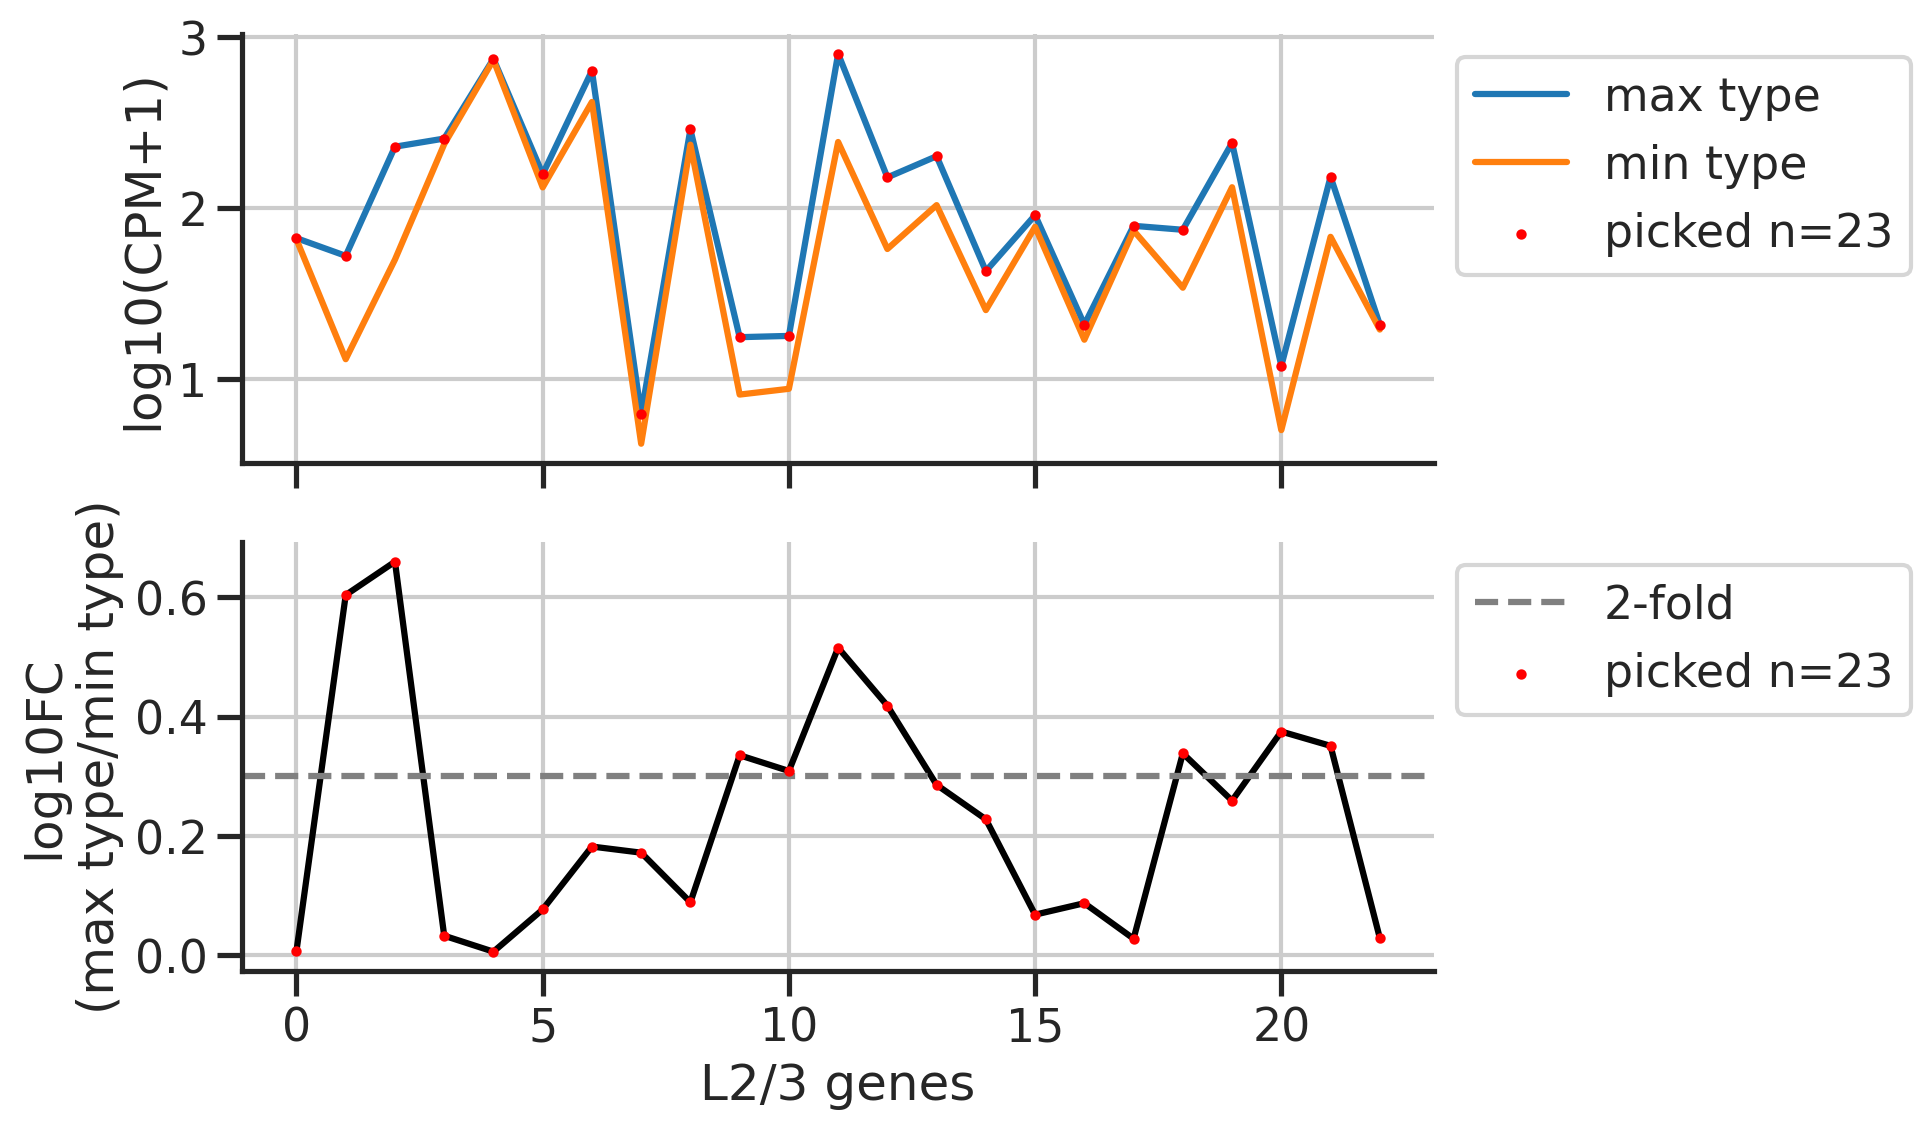

In [21]:
plot_l23genes()

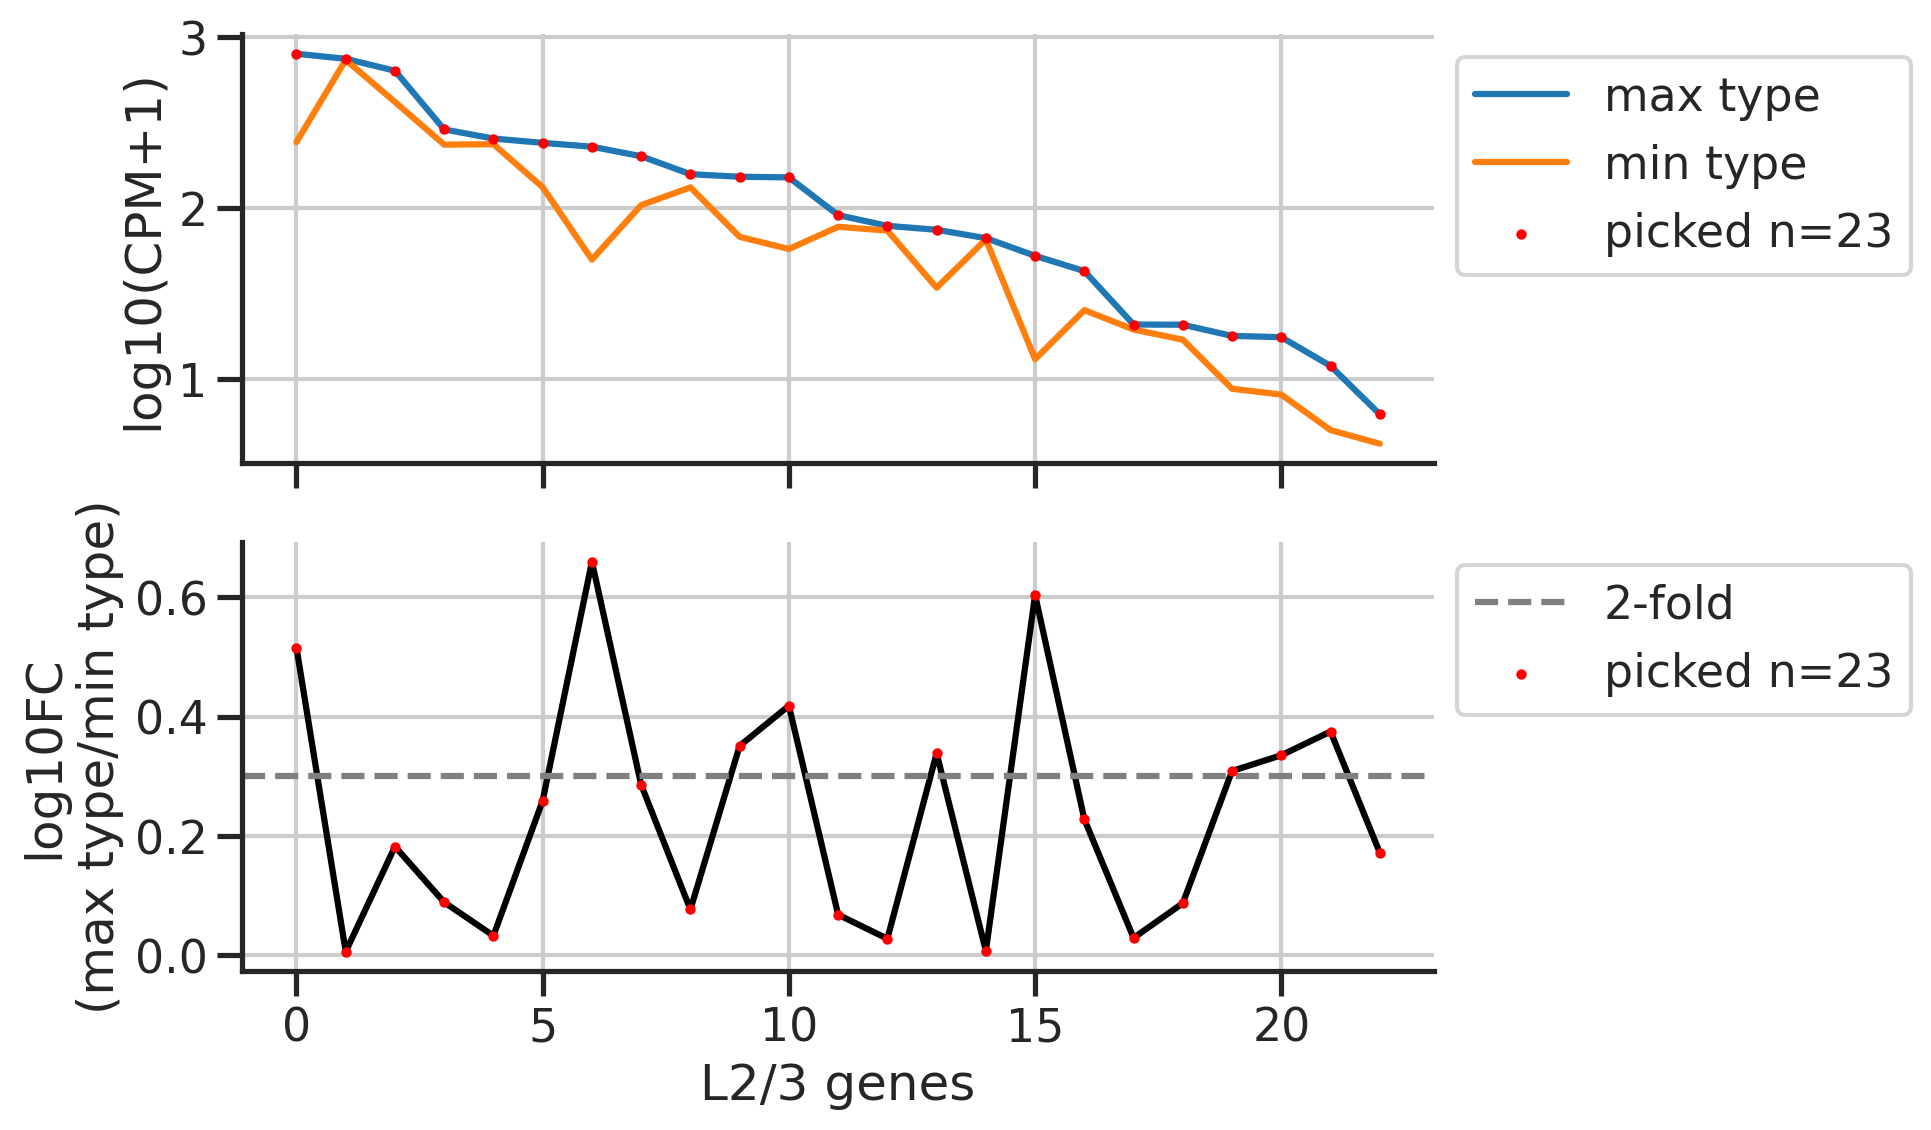

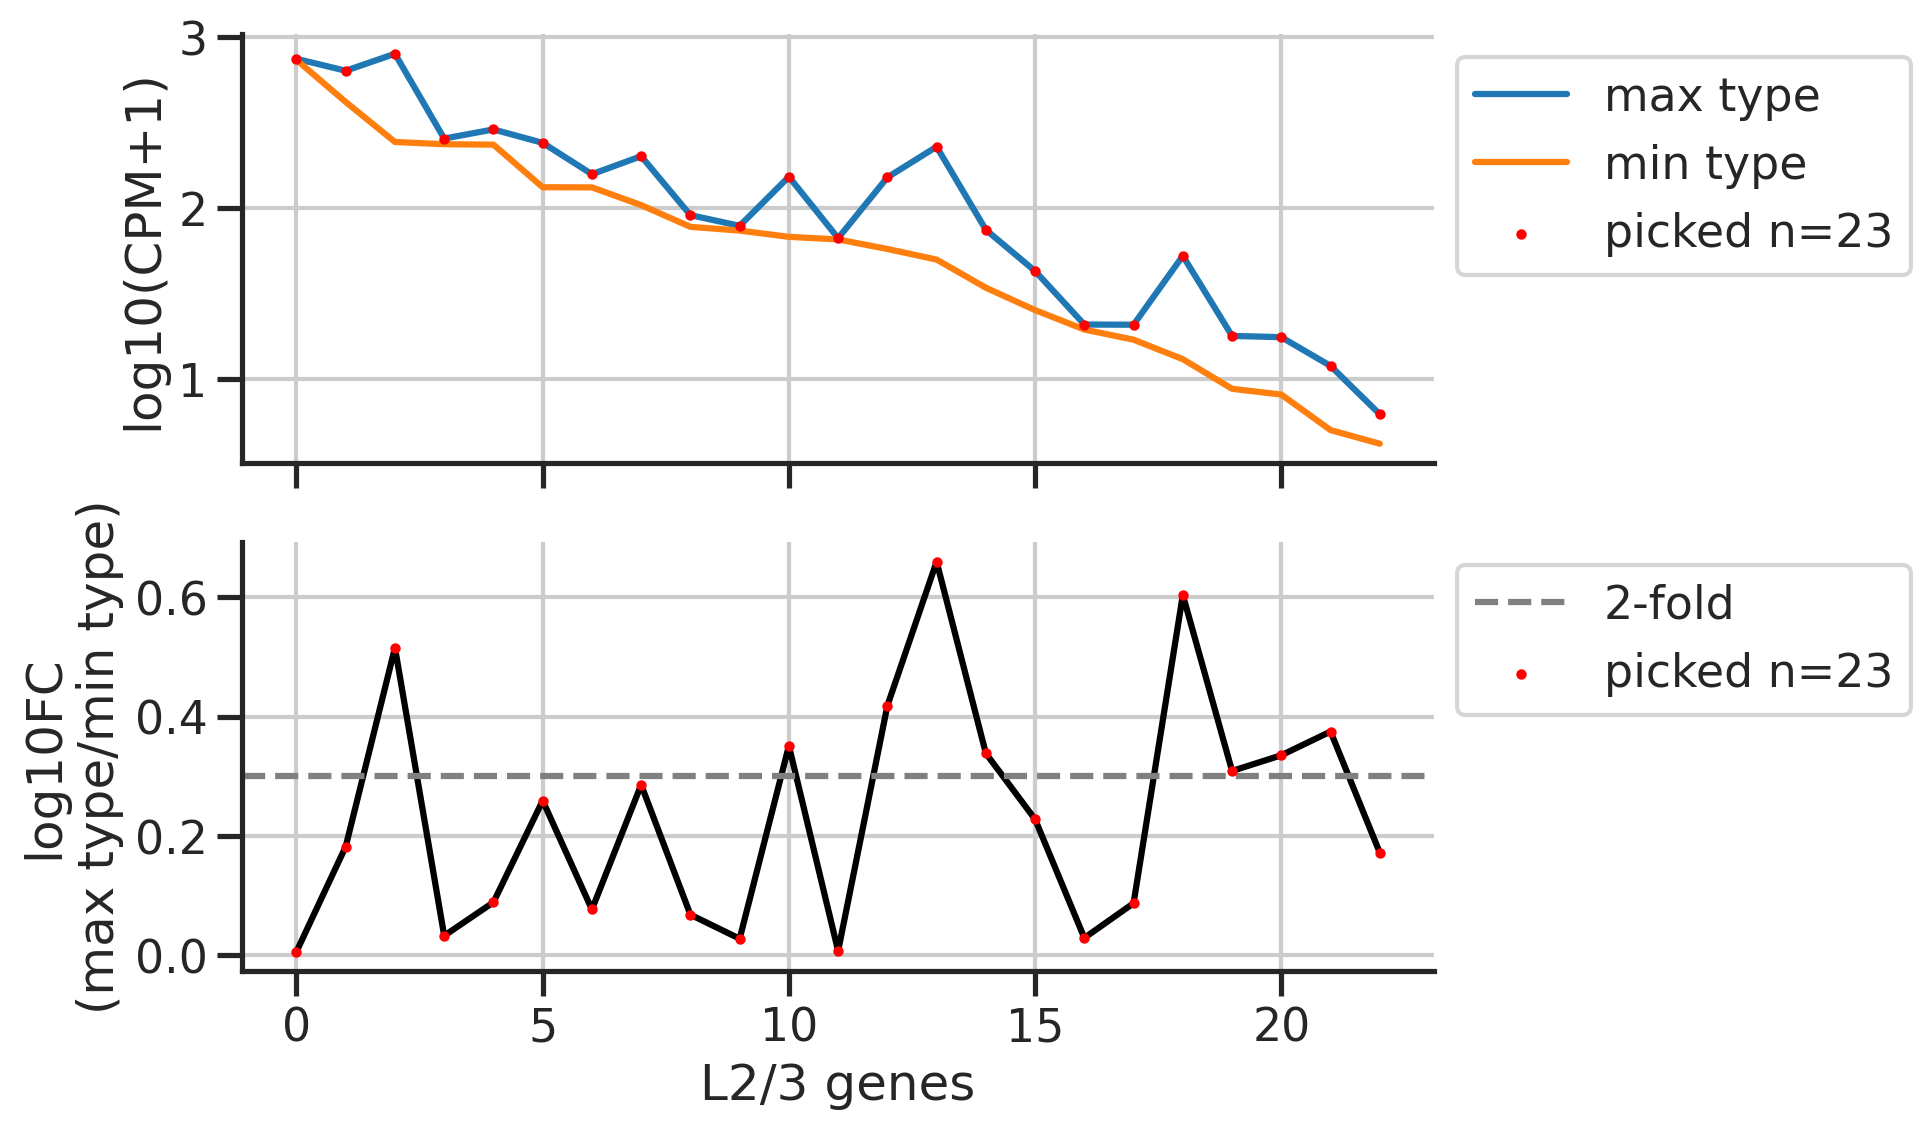

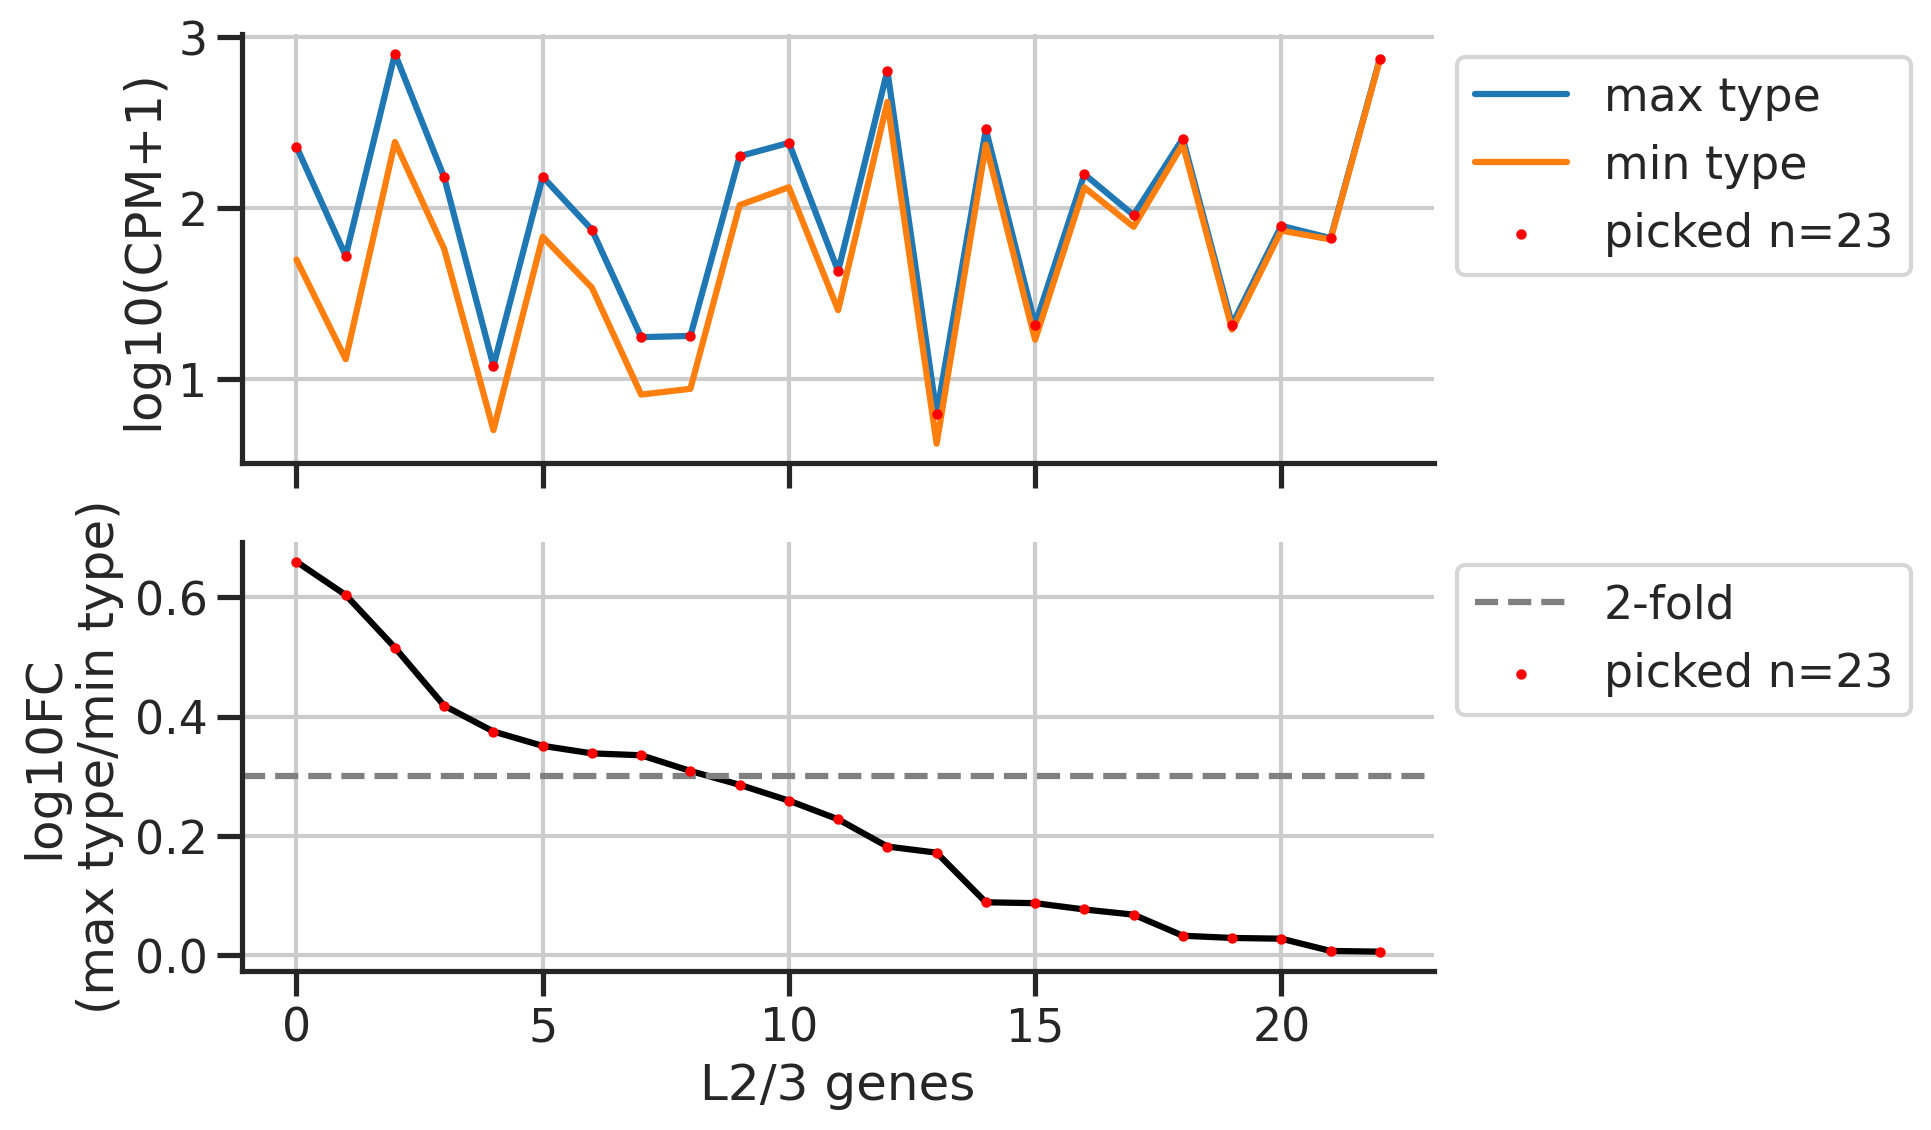

In [22]:
plot_l23genes(order=maxorder[::-1])
plot_l23genes(order=minorder[::-1])
plot_l23genes(order=lfcorder[::-1])

In [23]:
genes_l23[lfcexp < np.log10(2)]

array(['Dner', 'Cacnb2', 'Pde1a', 'Plcb4', 'Gm15155', '4921539H07Rik',
       'Npnt', 'Vgll4', 'Gm45846', 'Lama4', 'Gm15398', 'Slc35f4',
       'Pitpnc1', 'Mamdc2'], dtype=object)

In [24]:
genes_l23[np.logical_and(lfcexp<np.log10(2), ispicked)]


array(['Dner', 'Cacnb2', 'Pde1a', 'Plcb4', 'Gm15155', '4921539H07Rik',
       'Npnt', 'Vgll4', 'Gm45846', 'Lama4', 'Gm15398', 'Slc35f4',
       'Pitpnc1', 'Mamdc2'], dtype=object)